In [1]:
import numpy as np
from scipy import stats

from matplotlib import pyplot as plt
import seaborn as sns

from typing import Dict
from numpy import typing as npt
from sys import stderr

In [2]:
def read_chains(filename: str) -> Dict[str, npt.NDArray]:
    try:
        with open(filename, "r") as f:
            chains = dict()
            for line in f.readlines():
                name, *data = line.split()
                chains[name] = np.array(list(map(float, data)))
            return chains
    except IOError as e:
        print(f"{e}", file=stderr)
        return dict()

In [3]:
def generate_data(chain, n):
    SD = 0.2

    assert chain['theta0'].shape == chain['theta1'].shape
    assert chain['theta0'].shape == chain['log_posterior'].shape

    idxs = np.random.randint(0, chain['theta0'].shape[0], n)

    def gen(rho, mu):
        choice = np.random.uniform(0.0, 1.0)
        if (choice <= (1-rho)):
            return np.random.normal(0.0, SD)
        else:
            return np.random.normal(mu, SD)


    return np.array([gen(chain['theta0'][idx], chain['theta1'][idx]) for idx in idxs])

In [4]:
def get_no_hc_data(ns, orig_data, n_gen_iter):
    num_samples = orig_data.shape[0]

    dists = list()
    for n in ns:
        filename = f"../chen_convergence/no_hc_{n}.txt"
        chains = read_chains(filename=filename)

        ws_dist = 0
        for _ in range(n_gen_iter):
            synth_data = generate_data(chain=chains, n=num_samples)
            ws_dist += stats.wasserstein_distance(orig_data, synth_data)
        ws_dist /= n_gen_iter

        dists.append(ws_dist)

    return np.array(dists)

In [5]:
def get_with_hc_data(ns, orig_data, num_hypercubes, n_gen_iter):
    num_samples = orig_data.shape[0]

    dists = list()
    for n in ns:
        chains = [read_chains(f"../chen_convergence/with_hc_{n}_{i}.txt") for i in range(num_hypercubes)]
        chains_hc_comb = {key: np.concatenate([chain[key] for chain in chains]) for key in chains[0]}

        ws_dist = 0
        for _ in range(n_gen_iter):
            synth_data = generate_data(chain=chains_hc_comb, n=num_samples)
            ws_dist += stats.wasserstein_distance(orig_data, synth_data)
        ws_dist /= n_gen_iter

        dists.append(ws_dist)

    return np.array(dists)

In [6]:
def orig_model(n):
    P0, P1, P2 = 0.5, 0.45, 0.05
    assert P0 + P1 + P2 == 1.0

    M0, M1, M2 = 0.0, 0.75, 3.0
    SD = 0.2

    def gen():
        choice = np.random.uniform(0.0, 1.0)
        if (choice <= P0):
            return np.random.normal(M0, SD)
        elif (choice <= P0 + P1):
            return np.random.normal(M1, SD)
        else:
            return np.random.normal(M2, SD)

    return np.array([gen() for _ in range(n)])

In [7]:
min  = 10    # 10_000    # 1_000   
max  = 2000  # 2_000_000 # 200_000 
step = 50    # 50_000    # 5_000   
ns = [step * i if i > 0 else min for i in range(int(max / step + 1))]

n_gen_iter = 200

n = 1000
orig_data = orig_model(n)

In [8]:
no_hc_dists = get_no_hc_data(ns=ns, orig_data=orig_data, n_gen_iter=n_gen_iter)

In [9]:
NUM_HYPERCUBES = 2
with_hc_dists = get_with_hc_data(ns=ns, orig_data=orig_data, n_gen_iter=n_gen_iter, num_hypercubes=NUM_HYPERCUBES)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


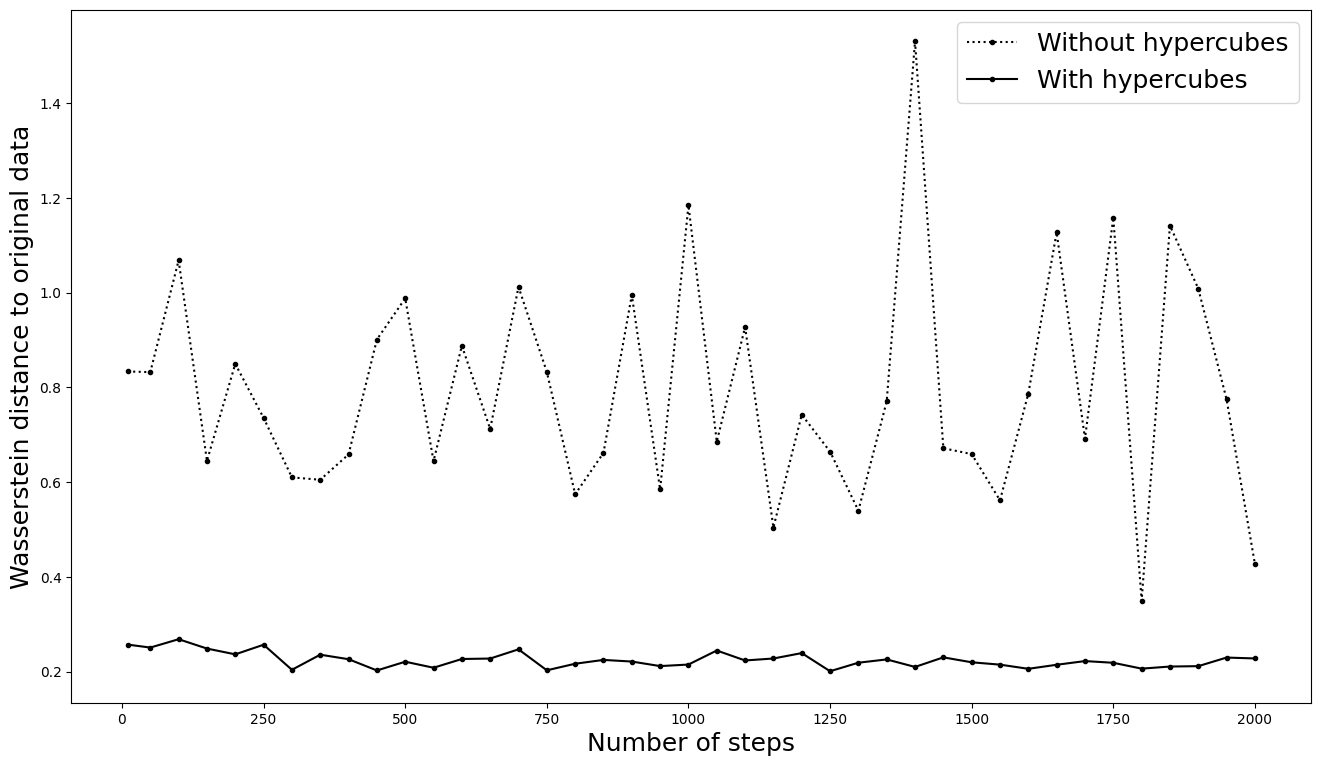

In [19]:
plt.figure(figsize=(16, 9))

plt.plot(ns, no_hc_dists, color="black", marker=".", linestyle=":", label="Without hypercubes")
plt.plot(ns, with_hc_dists, color="black", marker=".", linestyle="-", label="With hypercubes")

plt.xlabel("Number of steps", fontsize=18)
plt.ylabel("Wasserstein distance to original data", fontsize=18)
plt.legend(fontsize=18)

plt.savefig("../1d_chen_wasserstein_distance.eps")

plt.show()

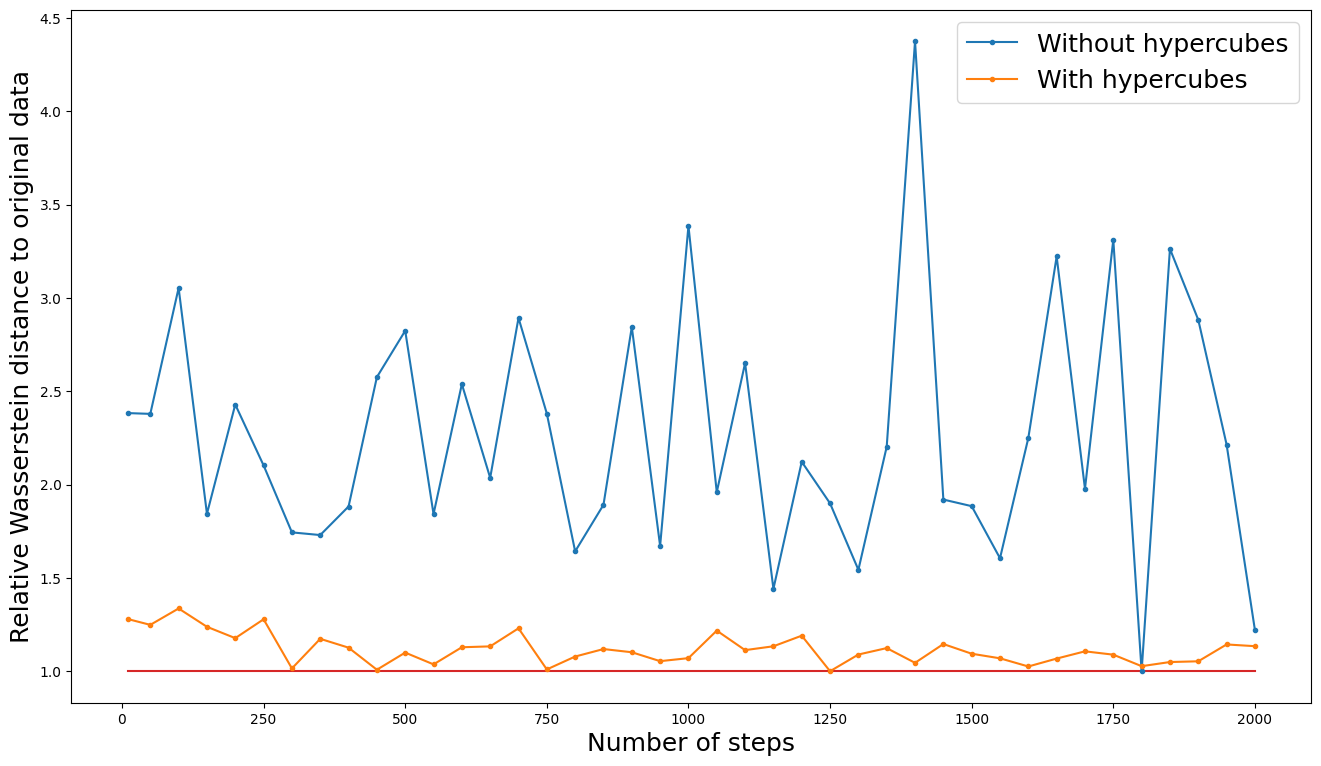

In [12]:
plt.figure(figsize=(16, 9))

plt.plot(ns, np.ones_like(ns), color="tab:red")
plt.plot(ns, no_hc_dists / np.min(no_hc_dists), marker=".", label="Without hypercubes")
plt.plot(ns, with_hc_dists / np.min(with_hc_dists), marker=".", label="With hypercubes")

plt.xlabel("Number of steps", fontsize=18)
plt.ylabel("Relative Wasserstein distance to original data", fontsize=18)
plt.legend(fontsize=18)

plt.show()